# **Visualisation**

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

**Data loading**

In [27]:
df = pd.read_csv('../data/data.csv')

**Severity level categorization function**

In [28]:
def cvss_to_severity(score):
    try:
        score = float(score)
        if score <= 3:
            return 'Faible'
        elif score <= 6:
            return 'Moyenne'
        elif score <= 8:
            return 'Élevée'
        else:
            return 'Critique'
    except:
        return 'Inconnu'

# 1. Histogram of severity levels (based on CVSS)

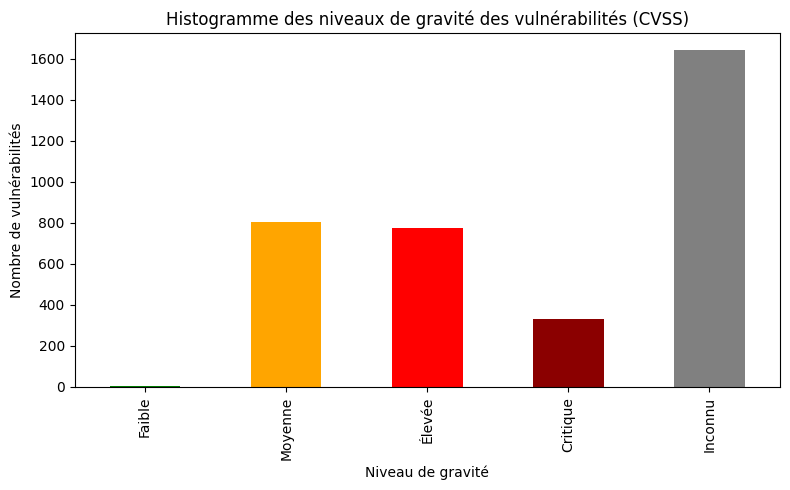

In [29]:
df['Gravité'] = df['CVSS'].apply(cvss_to_severity)
grav_counts = df['Gravité'].value_counts().reindex(['Faible', 'Moyenne', 'Élevée', 'Critique', 'Inconnu'], fill_value=0)

# Plot
plt.figure(figsize=(8,5))
grav_counts.plot(kind='bar', color=['green', 'orange', 'red', 'darkred', 'gray'])
plt.title('Histogramme des niveaux de gravité des vulnérabilités (CVSS)')
plt.xlabel('Niveau de gravité')
plt.ylabel('Nombre de vulnérabilités')
plt.tight_layout()
plt.savefig("../Visualisation/histogramme_gravite.png")
plt.show()

# 2. Circular vulnerability diagram (CWE)

Data cleaning

In [30]:
df['CWE'] = df['CWE'].fillna('Inconnu')

Top 10 most frequents, the other gouped by "Others"

In [31]:
top_cwe = df['CWE'].value_counts()
top_10 = top_cwe.head(10)
autres = top_cwe[10:].sum()
top_10['Autres'] = autres

Plot

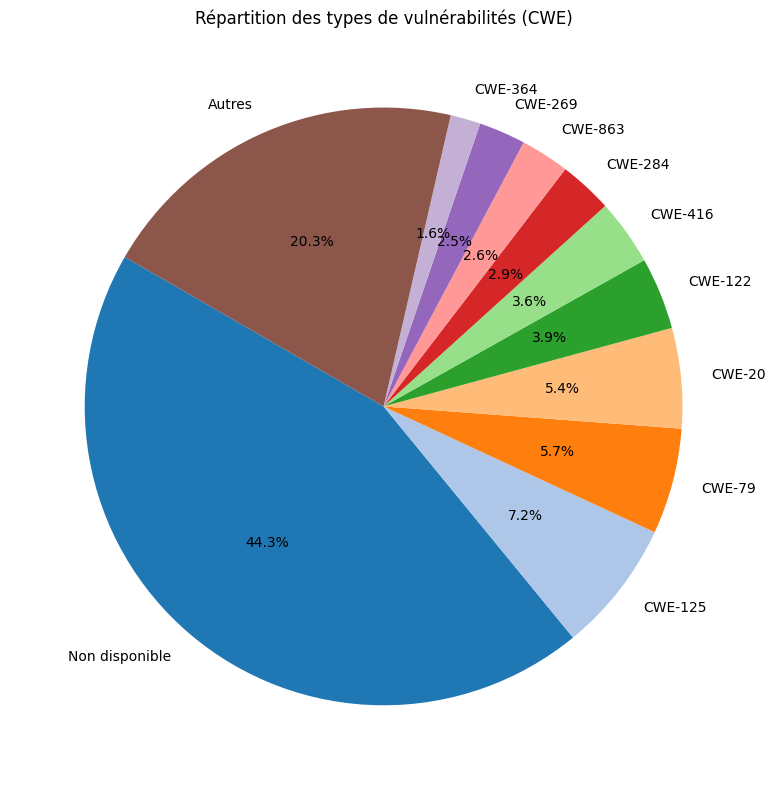

In [32]:
plt.figure(figsize=(8,8))
colors = plt.cm.tab20.colors[:len(top_10)]
top_10.plot(kind='pie', autopct='%1.1f%%', startangle=150, colors=colors)
plt.title('Répartition des types de vulnérabilités (CWE)')
plt.ylabel('')
plt.tight_layout()
plt.savefig("../Visualisation/camembert_CWE.png")
plt.show()

# 3. EPSS Score Density Curve

Ensure EPSS scores are numeric

In [33]:
df['EPSS'] = pd.to_numeric(df['EPSS'], errors='coerce')
epss_valid = df['EPSS'].dropna()

Plot

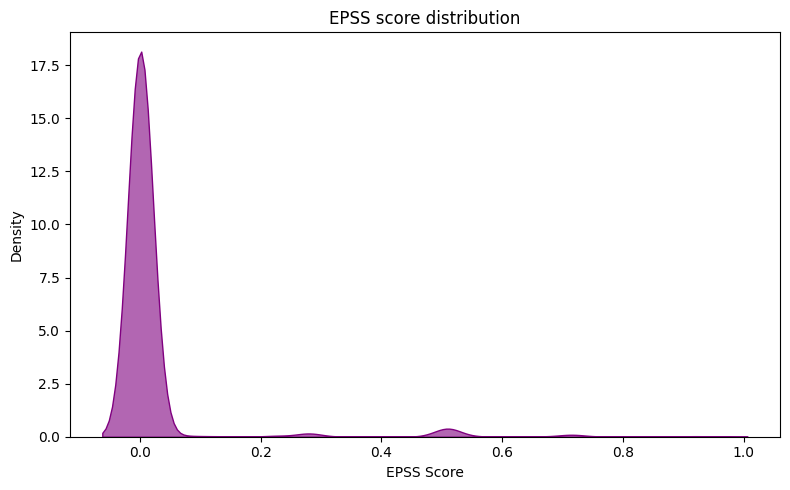

In [34]:
plt.figure(figsize=(8, 5))
sns.kdeplot(epss_valid, fill=True, color="purple", alpha=0.6)
plt.title('EPSS score distribution')
plt.xlabel('EPSS Score')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig("../Visualisation/epss_curve.png")
plt.show()

# 4. Top Affected editors

Count top 10 most frequently affected editors

In [35]:
top_editors = df['Éditeur'].value_counts().head(10)

Plot

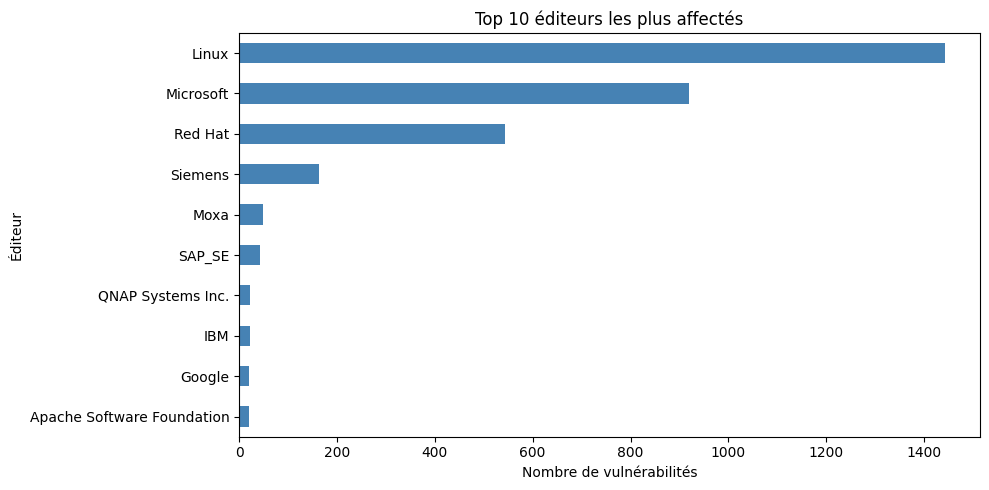

In [36]:
plt.figure(figsize=(10, 5))
top_editors.plot(kind='barh', color='steelblue')
plt.title('Top 10 éditeurs les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../Visualisation/top_affected_editors.png")
plt.show()

# 5. Top affected products

Count top 10 most frequently affected products

In [37]:
top_products = df['Produit'].value_counts().head(10)

Plot

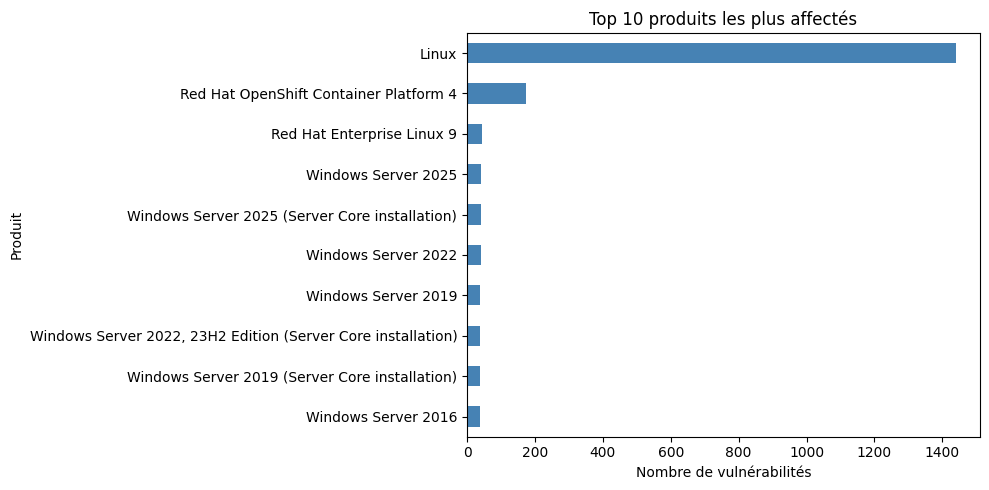

In [38]:
plt.figure(figsize=(10, 5))
top_products.plot(kind='barh', color='steelblue')
plt.title('Top 10 produits les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("../Visualisation/top_affected_products.png")
plt.show()

# 6. Heatmap : Correlation between CVSS and EPSS

In [39]:
df["CVSS"] = pd.to_numeric(df["CVSS"], errors="coerce")

Create a correlation dataframe

In [40]:
correlation_df = df[["CVSS", "EPSS"]].dropna()

In [41]:
df["Gravité_CVSS"] = df["CVSS"].apply(cvss_to_severity)

Categorize EPSS into 4 probability bins

In [42]:
def epss_to_level(epss):
    if epss <= 0.25:
        return "Faible"
    elif epss <= 0.5:
        return "Moyenne"
    elif epss <= 0.75:
        return "Élevée"
    else:
        return "Critique"

In [43]:
df["Probabilité_EPSS"] = df["EPSS"].apply(epss_to_level)

Create heatmap

In [44]:
heatmap_data = pd.crosstab(df["Gravité_CVSS"], df["Probabilité_EPSS"])
heatmap_data = heatmap_data.reindex(index=["Critique", "Élevée", "Moyenne", "Faible"],
                                     columns=["Faible", "Moyenne", "Élevée", "Critique"])

Plot

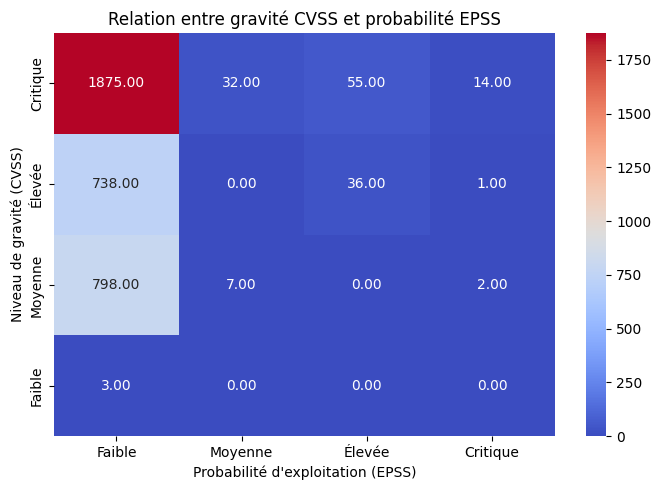

In [45]:
plt.figure(figsize=(7, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Relation entre gravité CVSS et probabilité EPSS")
plt.xlabel("Probabilité d'exploitation (EPSS)")
plt.ylabel("Niveau de gravité (CVSS)")
plt.tight_layout()
plt.savefig("../Visualisation/heatmap_cvss_vs_epss.png")
plt.show()

# 7. Scatter plot : CVSS vs EPSS

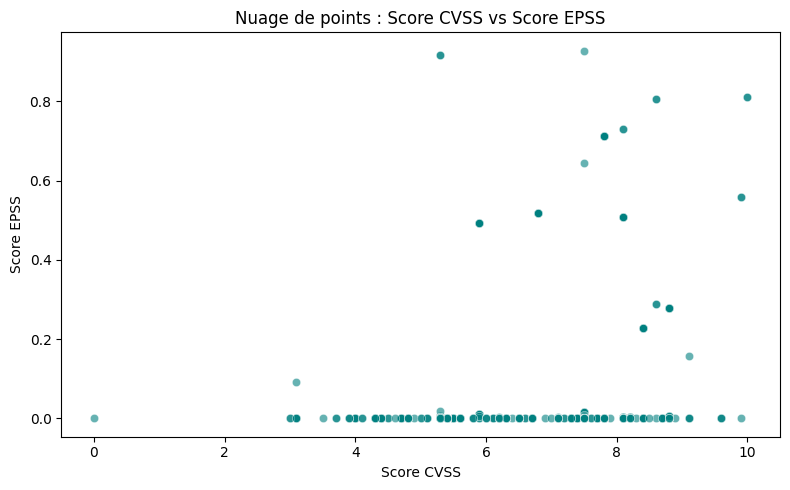

In [46]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="CVSS", y="EPSS", alpha=0.6, color="teal")
plt.title("Nuage de points : Score CVSS vs Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.tight_layout()
plt.savefig("../Visualisation/scatter_cvss_epss.png")
plt.show()

# 8. Cumulative curve: Vulnerabilities over time

In [47]:
df_sorted = df.sort_values("Date").dropna(subset=["Date"])

Group by date and calculate cumulative sum

In [48]:
cumulative_df = df_sorted.groupby("Date").size().cumsum()

Plot

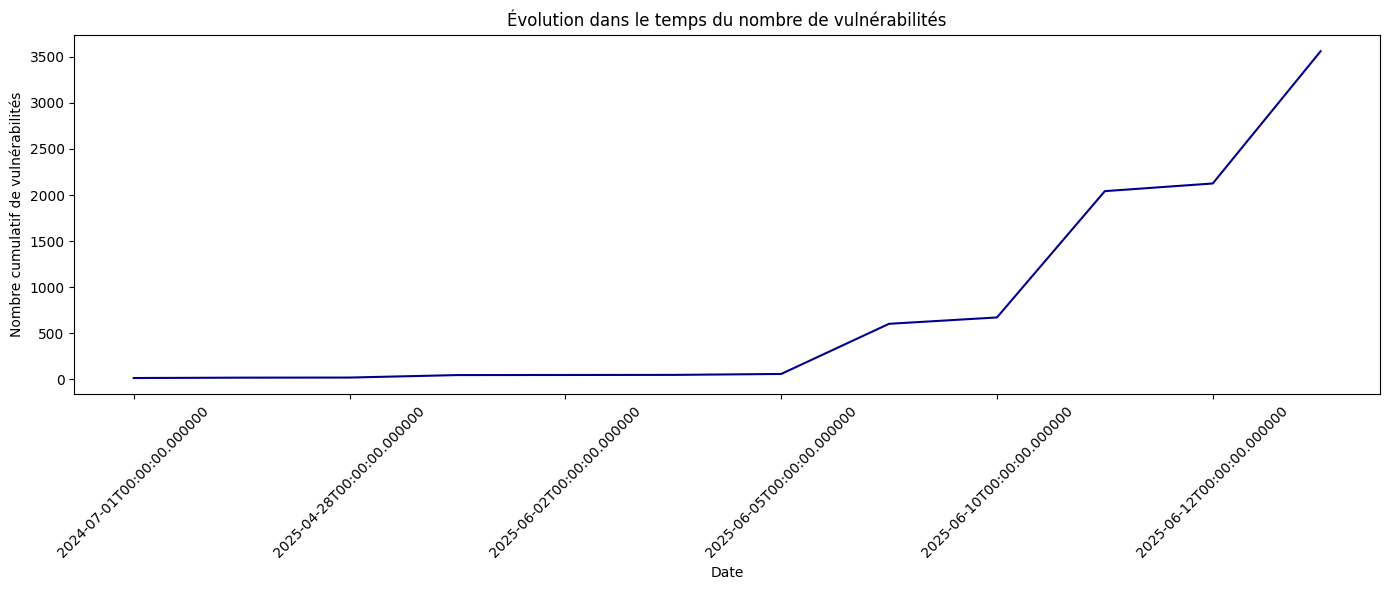

In [49]:
plt.figure(figsize=(14, 6))
ax = cumulative_df.plot(color="darkblue")
plt.title("Évolution dans le temps du nombre de vulnérabilités")
plt.xlabel("Date")
plt.ylabel("Nombre cumulatif de vulnérabilités")
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.tight_layout()
plt.savefig("../Visualisation/courbe_cumulative_temps.png")
plt.show()

# 9. Boxplot : CVSS scores by top editors

Filter

In [50]:
top_editors = df['Éditeur'].value_counts().head(10).index
boxplot_df = df[df['Éditeur'].isin(top_editors)]

Plot

C:\Users\eva2p\AppData\Local\Temp\ipykernel_28712\391111385.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')


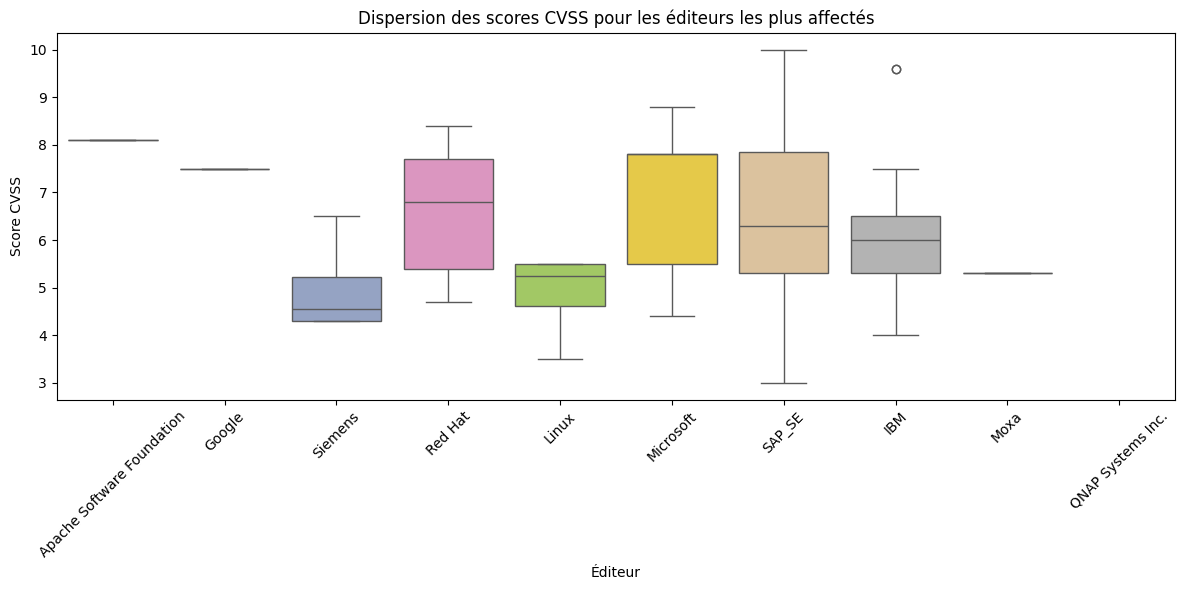

In [52]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')
plt.title('Dispersion des scores CVSS pour les éditeurs les plus affectés')
plt.xlabel('Éditeur')
plt.ylabel('Score CVSS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../Visualisation/boxplot_cvss_par_editeur.png")
plt.show()

# 10. Time evolution of CWE-79 vulnerabilities (Cross-Site Scripting)

In [56]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
cwe_79_df = df[df["CWE"] == "CWE-79"]

Group by month

In [57]:
cwe_79_monthly = cwe_79_df.groupby(df["Date"].dt.to_period("M")).size()
cwe_79_monthly.index = cwe_79_monthly.index.to_timestamp()

Plot

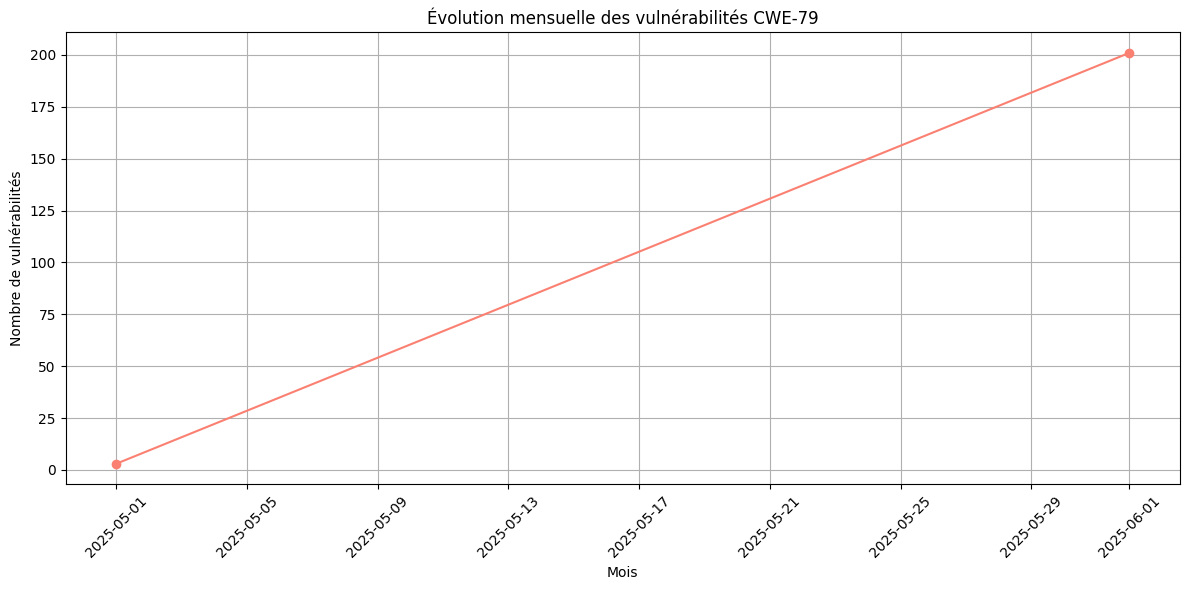

In [58]:

plt.figure(figsize=(12, 6))
plt.plot(cwe_79_monthly.index, cwe_79_monthly.values, marker="o", linestyle="-", color="salmon")
plt.title("Évolution mensuelle des vulnérabilités CWE-79")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("../Visualisation/evolution_CWE79.png")
plt.show()

# 11. Histogram of vulnerabilities by product for a given CWE

Selection of CWE-125

In [62]:
cwe_cible = "CWE-125"
df_cwe = df[df["CWE"] == cwe_cible]

Count vulnerabilities by product

In [63]:
produit_counts = df_cwe["Produit"].value_counts().sort_values(ascending=False).head(15)

Plot

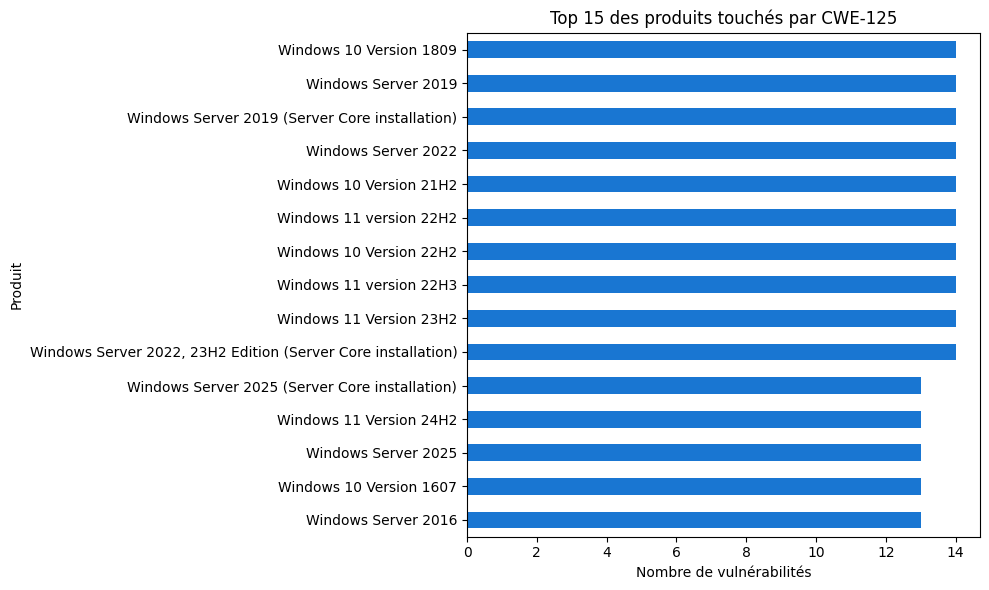

In [64]:
plt.figure(figsize=(10,6))
produit_counts.plot(kind="barh", color="#1976D2")
plt.gca().invert_yaxis()
plt.title(f"Top 15 des produits touchés par {cwe_cible}")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Produit")
plt.tight_layout()
plt.savefig("../Visualisation/product_vulnerabilities_for_CWE-125.png")
plt.show()

# 12. Heatmap CWE x editor

Cleaning

In [65]:
df["Éditeur"] = df["Éditeur"].fillna("Non précisé")

Heatmap

In [66]:
heatmap_data = pd.crosstab(df["CWE"], df["Éditeur"])

Selection (if not too many values)

In [73]:
top_cwe = heatmap_data.sum(axis=1).sort_values(ascending=False).head(15).index
top_editeurs = heatmap_data.sum(axis=0).sort_values(ascending=False).head(14).index
filtered_data = heatmap_data.loc[top_cwe, top_editeurs]

Plot

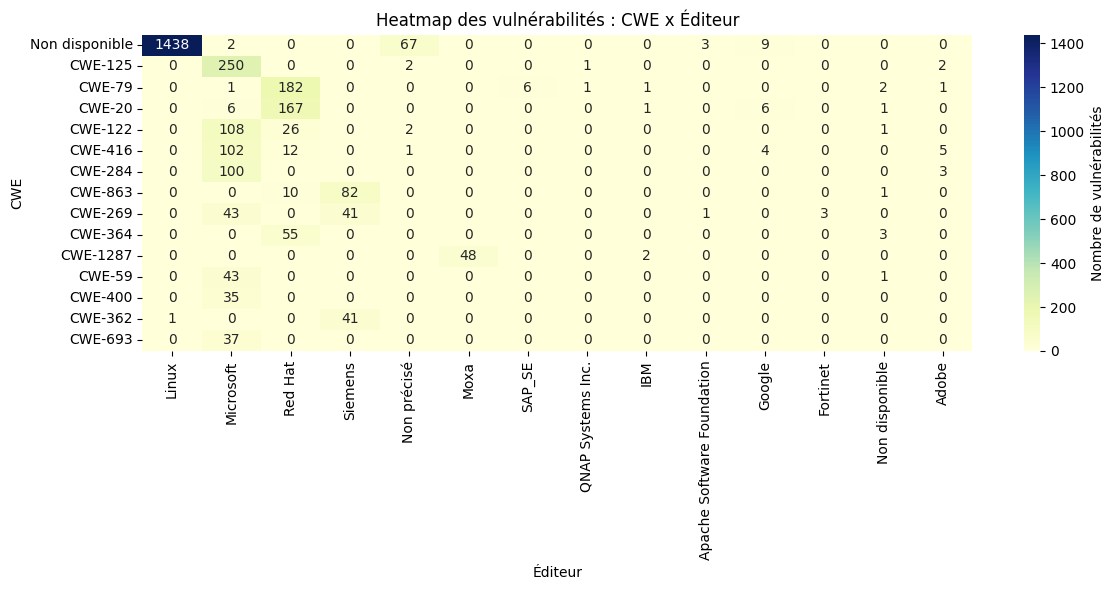

In [74]:
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Nombre de vulnérabilités'})
plt.title("Heatmap des vulnérabilités : CWE x Éditeur")
plt.xlabel("Éditeur")
plt.ylabel("CWE")
plt.tight_layout()
plt.savefig("../Visualisation/heatmap_CWE_editor.png")
plt.show()

# 13. Monthly vulnerability trends by CWE (superimposed curves)

Extraction of the month and the year

In [75]:
df["Mois"] = df["Date"].dt.to_period("M")  # Format AAAA-MM

Keep only the 8 most frequent CWE

In [76]:
top_cwes = df["CWE"].value_counts().head(8).index
df_top = df[df["CWE"].isin(top_cwes)]

Grouping: number of vulnerabilities per month and per CWE

In [77]:
df_grouped = df_top.groupby(["Mois", "CWE"]).size().unstack(fill_value=0)

Plot

<Figure size 1200x600 with 0 Axes>

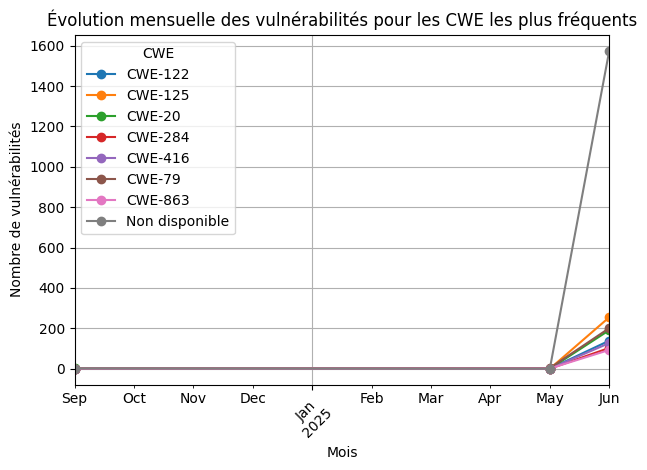

In [78]:
plt.figure(figsize=(12, 6))
df_grouped.plot(marker="o")
plt.title("Évolution mensuelle des vulnérabilités pour les CWE les plus fréquents")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.legend(title="CWE")
plt.tight_layout()
plt.savefig("../Visualisation/evolution_vulnerabilities_by_CWE_time.png")
plt.grid(True)
plt.show()

# 14. Heatmap : temporal vunerabilities

In [79]:
df["Année"] = df["Date"].dt.year
df["Mois"] = df["Date"].dt.month

In [80]:
pivot = pd.crosstab(df["Année"], df["Mois"]).fillna(0)

Plot

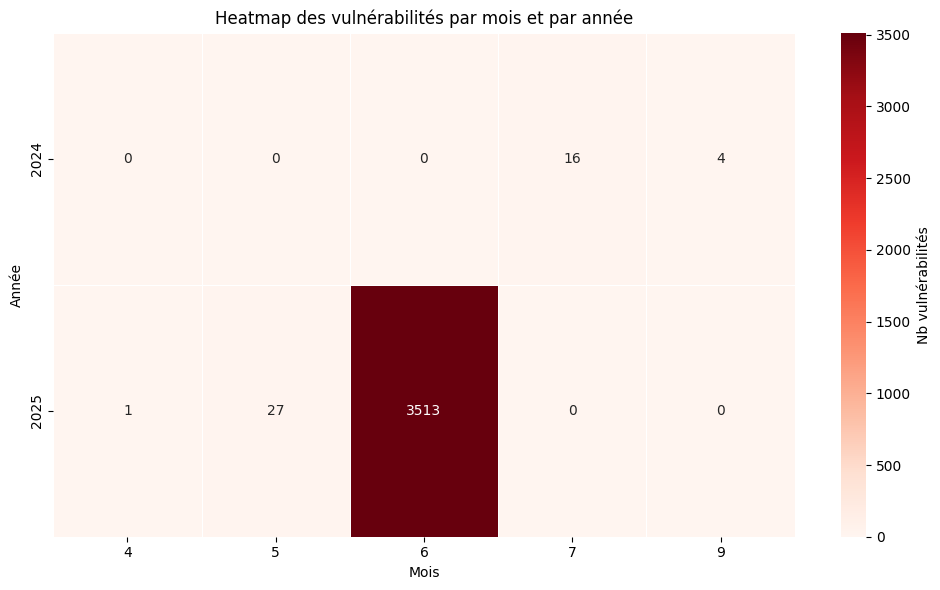

In [81]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="Reds", annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Nb vulnérabilités'})
plt.title("Heatmap des vulnérabilités par mois et par année")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.tight_layout()
plt.show()